In [1]:
# import...
import numpy as np
import os
import sys
import pandas as pd
from geopy import distance
import metpy.calc as mpcalc
import xarray as xr
import math
import matplotlib.pyplot as plt
os.chdir("/Users/etmu9498/research/code/scripts-winter2023")
import helper_fns_winter2023
os.chdir("/Users/etmu9498/research/code/scripts-winter2023/cloud-top-height-stats")
import eyewall_metadata


In [2]:
# os.chdir("/Users/etmu9498/research/data/crl-all-data-processed/2021")
# d = xr.open_dataset('P3_20210929H2_processed.nc')
 #d

In [3]:
# code taken from "scripts-winter2023/fl-data-processing/find_fl_dists_rmws.py"

def find_cartesian_shear_coords( tc='all'):
    # use a helper fn to get the relevant years and files
    yearlist, crlfilelist = helper_fns_winter2023.get_crl_datasets( tc=tc)

    alldates = []
    allxdists = []
    allydists = []
    alltimes = []
    
    # print out the number of files to be saved
    filecount = 0
    for yeari in range( len( crlfilelist)):
        # count all the names in this year, and add to the count
        filecount += len( crlfilelist[ yeari])
    print("Number of data files to be plotted: " + str( filecount))
    print( 'data saved to: /Users/etmu9498/research/figures/CRL-all-data-processed/"year"-clusters-"cluster type')

    # do this for all the datasets! years and filenames
    for yeari, yearval in enumerate( yearlist):
        for filei, crlname in enumerate( crlfilelist[ yeari]):
            print("Date: " + crlname[3:13])
                        
            os.chdir("/Users/etmu9498/research/data/crl-all-data-processed/" + yearval + "/")
            crl_data = xr.open_dataset(crlname)
            float_time = crl_data.time.values
            
            # print(float_time[0])
            # print(float_time[-1])
            
            # step 0: 
            # find a matching flight level dataset! Given the year and crl file name
            # first, go to the correct year folder for the crl / fl case
            flpath = "/Users/etmu9498/research/data/in-situ-noaa-processed/" + yearval
            # get a list of the files within this folder
            fllist = helper_fns_winter2023.load_flight_level( flpath, print_files=False)
            # go through all of the files within fllist. Save all the ones with matching dates
            # with the crl data in a new list!
            matchlist = []
            for fl_filei, fl_fileval in enumerate( fllist):
                if crlname[3:-13] == fl_fileval[ : 10]:
                    matchlist.append( fl_fileval)
            # error cases: either too many files with the same date from the same plane, or no valid files!
            if len( matchlist) == 0:
                print(crlname[3:-18])
                print( "Error! No flight level dataset found. Investigate!")
            elif len( matchlist) > 1:
                print( "Error! Too many flight level datasets found for the same date and aircraft. Investigate!")
                print(crlname[3:-18])
            else:
                flname = matchlist[0]
                tcname = flname[ 11 : -13]
            
            #######
            ## step 1.1: see if there's valid track data for this case
            #######
            # make the track file name
            track_data_list = []
            track_file_path = "/Users/etmu9498/research/data/track/"
            trackfilename = tcname + yearval + ".trak"
            # load the files in the track folder: is this tc case present?
            trackfiles = helper_fns_winter2023.load_flight_level( track_file_path, print_files=False)
            count = trackfiles.count( trackfilename)
            if count == 0:
                print( "No track file for TC " + tcname + " present. Nans saved in dist and rmw axis.")
                nanarray = np.empty( len( float_time))
                nanarray[:] = np.nan
            elif count != 1:
                print( "Duplicate cases?")
                
            #######
            ## step 1.2: load the tc track data!
            #######
            # account for annoying laura2020 case: extra values given for some reason
            # see if other cases have the same issue??
            track_data_temp = pd.read_fwf( track_file_path + trackfilename, skiprows=3)
            # laura case
            if np.shape( track_data_temp)[1] == 8:
                col_names = ['date', 'time (UTC)', 'lat', 'lat dir', 'lon', 'lon dir', 'temp1', 'temp2']
            else:
                col_names = ['date', 'time (UTC)', 'lat', 'lat dir', 'lon', 'lon dir']
            track_data = pd.read_fwf( track_file_path + trackfilename, skiprows=3, names = col_names)

            # add a new column with time as a decimal
            float_times = []
            for ind in range( np.shape( track_data)[0]):
                str_timei = track_data['time (UTC)'][ ind]
                # calculate the decimal time
                h = float( str_timei[0:2])
                m = float( str_timei[3:5])
                s = float( str_timei[6:8])
                float_times.append( h + m / 60 + s / 3600)
            track_data[ 'float_time'] = float_times
            # add a new column with the date in the format of new flight level netcdfs
            newdates = []
            for ind in range( np.shape( track_data)[0]):
                old_datei = track_data.date[ ind]
                newdates.append( old_datei[6:10] + old_datei[0:2]+old_datei[3:5])
            track_data[ 'date2'] = newdates

            #######
            ## step 1.3: trim down the time ranges on the track data to prevent looking at tracks outside the correct limits!
            #######
            # find flight level (fl) time limits for the current and sometimes the next day
            fl_date = flname[0:8]
            fl_firstt = float_time[0]
            fl_lastt = float_time[-1]
            # cut off all data before the start of the p-3 data
            # find the indices for the times from the first day
            current_day_inds = np.where( track_data['date2'] == flname[0:8])[0]

            # case where the date of this flight isn't even included in the track list! way outside of bounds.
            # just return nans
            if len( current_day_inds) == 0:
                print( "Flight level date completely before provided track. Skipping this case.")
                nanarray = np.empty( len( float_time))
                nanarray[:] = np.nan

                continue
                
            # find the closest time to the start time!
            # need to do first_day_inds[0] to account for indices before the start of first_day_inds!
            first_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - fl_firstt ))

            newdate = []
            # find the closest time to the end time!
            # same day CASE
            if fl_lastt < 24.0:
                last_t_ind = current_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ current_day_inds].values - fl_lastt ))
            # new case: the float_time variable shifts into the next day
            # need to look at arrays for the next day
            else:
                # find the next day indices.
                # done this way rather than + 1 to account for flips like 9/29 -> 9/30, or 9/31 -> 10/1
                # look through dates from current day to the end of the array
                for datei in track_data['date2'][ current_day_inds[0] : ]:
                    # new date case: save it and end the loop!
                    if datei != flname[0:8]:
                        newdate = datei
                        break
                # the same sorting if statement as below: find cases that come completely after the last track time :(
                if len( newdate) == 0:
                    print( "Flight level date completely after provided track. Nans saved in dist and rmw axis.")
                    nanarray = np.empty( len( float_time))
                    nanarray[:] = np.nan
                    return nanarray, nanarray
                # still in the if statement, find all the inds for this next day
                next_day_inds = np.where( track_data['date2'] == newdate)[0]
                # do - 24 to account for the 24 hour shift!
                last_t_ind = next_day_inds[0]  + np.argmin( np.abs( track_data['float_time'][ next_day_inds].values - ( fl_lastt - 24) ))
            # make the final array!
            dayind = range( first_t_ind, last_t_ind)

            ########
            ## step 1.4: find the tc center distance!
            ## somewhat time consuming but accurate
            ########
            lat = crl_data.Lat.values
            lon = crl_data.Lon.values
            track_lat = track_data.lat.values [dayind]
            track_lon = - track_data.lon.values [dayind] # values are saved as positive from track .txt document
            tracktime = track_data.float_time.values [dayind]
            trackdate = track_data.date2.values [ dayind]

            # case where the date of this flight is included in the track list, but the first time is way past
            # the last time in the track list
            # just return nans
            if len( tracktime) == 0:
                print( "Flight level date completely after provided track. Nans saved in dist and rmw axis.")
                nanarray = np.empty( len( float_time))
                nanarray[:] = np.nan
                continue
         
            # first, account for date changes in the time intervals:
            fl_orig_date = flname[0:8] # the date when the first pass was completed
            for tracktimei in range( len( tracktime)):
                # new date case: increase the time by 24 hours!
                if trackdate [ tracktimei] != fl_orig_date:
                    tracktime[ tracktimei] += 24.0
            latnans = 0
            lonnans = 0
            far_dist = False
            
            xdists, ydists = [], []
            for fl_i in range( len( crl_data.Lat)):
                lati, loni, timei = lat[ fl_i], lon[ fl_i], float_time[ fl_i]

                # find the closest center fix time index!
                #########################
                ## 2/13/23 new code: make sure that the closest center fix time is at least smaller than 15 minutes (?)
                ## and that the date is within the correct bounds!
                ## if the time difference is too large, then add nans for this case :/
                ## helpful for avoiding edge case errors ( a 15 minute window is used??)
                #########################
                if np.min( np.abs( tracktime - timei )) > .50 :
                    latnans += 1
                    lonnans += 1
                    # print out a helpful warning to the user for out of range fl times!
                    # the far_dist flag is to make sure that this is only printed out once :)
                    if not far_dist:
                        far_dist = True
                        print( "Flight level times are out of range from valid track times (either too early or late.)" +
                                " Nans have been added to the center_dist and rmw array.")
                    continue
                else:
                    center_i = np.argmin( np.abs( tracktime - timei ))
                    center_time = tracktime[ center_i]
                    center_date = trackdate[ center_i]
                    coords_p3 = np.ma.masked_invalid( ( lati, loni))
                    coords_center = np.ma.masked_invalid( ( track_lat[center_i], track_lon[center_i]))

                    # center_dist_i = distance.geodesic( coords_p3, coords_center).km                    
                    # xdist_simplei =  ( abs(coords_center[1]) - abs(coords_p3[1])) * 111.32 * math.cos( math.radians(coords_p3[0]))
                    # ydist_simplei =  (coords_p3[0] - coords_center[0]) * 110.574
                    
                    xdist_simplei = distance.geodesic( np.ma.masked_invalid((track_lat[center_i], loni)), coords_center).km # .astype(str).str[:-3].astype(float)
                    ydist_simplei = distance.geodesic( np.ma.masked_invalid((lati, track_lon[center_i])), coords_center).km # .astype(str).str[:-3].astype(float)
                    
                    # - x correction case
                    if abs( loni) > abs( track_lon[center_i]): 
                        xdist_simplei = - xdist_simplei
                    # - y case
                    if abs( lati) < abs( track_lat[center_i]):
                        ydist_simplei = - ydist_simplei
                    
                    # nan cases- can't find a distance
                    if np.isnan( lati):
                        latnans += 1
                        xdist_simplei = np.nan
                        ydist_simplei = np.nan
                    if np.isnan( loni):
                        lonnans += 1
                        xdist_simplei = np.nan
                        ydist_simplei = np.nan
                    # otherwise, append a valid distance to the dists list
                    xdists.append( xdist_simplei)
                    ydists.append( ydist_simplei)
      
            # print out helpful notices and add distances to total list!
            print('number of lat nans: ' + str( latnans))
            print('number of lon nans: ' + str( lonnans))
            allxdists.append(xdists)
            allydists.append(ydists)
            alltimes.append(float_time)
            alldates.append(crlname[3:13])


    # at the end, return the total lists!
    return alldates, alltimes, allxdists, allydists
                    
    # testing code below: the array manipulation checks out really nicely!!
    '''
    if fl_i % 2000 == 0:
        print(xdist_simplei)
        print( distance.geodesic( np.ma.masked_invalid((track_lat[center_i], loni)), coords_center))
        print(ydist_simplei)
        print( distance.geodesic( np.ma.masked_invalid((lati, track_lon[center_i])), coords_center))
        print('\n')
    '''


In [4]:
alldates, alltimes, allxdists, allydists = find_cartesian_shear_coords()

Number of data files to be plotted: 35
data saved to: /Users/etmu9498/research/figures/CRL-all-data-processed/"year"-clusters-"cluster type
Date: 20210811H1
number of lat nans: 0
number of lon nans: 0
Date: 20210812H1
number of lat nans: 0
number of lon nans: 0
Date: 20210812H2
number of lat nans: 0
number of lon nans: 0
Date: 20210813H1
number of lat nans: 0
number of lon nans: 0
Date: 20210816H1
number of lat nans: 0
number of lon nans: 0
Date: 20210817H1
number of lat nans: 0
number of lon nans: 0
Date: 20210818H1
number of lat nans: 0
number of lon nans: 0
Date: 20210819H1
number of lat nans: 0
number of lon nans: 0
Date: 20210820H1
number of lat nans: 0
number of lon nans: 0
Date: 20210821H2
number of lat nans: 0
number of lon nans: 0
Date: 20210827H1
number of lat nans: 0
number of lon nans: 0
Date: 20210828H1
number of lat nans: 0
number of lon nans: 0
Date: 20210829H1
Flight level times are out of range from valid track times (either too early or late.) Nans have been added to 

In [5]:
# save date, time, distance data as a dataframe?
df_dists = pd.DataFrame()
df_dists['dates'] = alldates
df_dists['times'] = alltimes
df_dists['xdists'] = allxdists
df_dists['ydists'] = allydists

df_dists.to_pickle("/Users/etmu9498/research/data/detailed_distances_v2.pkl")

In [6]:
print(type( df_dists['xdists'][0][0]))

<class 'float'>


In [7]:
# load saved distances easily here!

# pd.read_pickle("/Users/etmu9498/research/data/detailed_distances.pkl")
# pd.read_pickle("/Users/etmu9498/research/data/simple_distances.pkl")

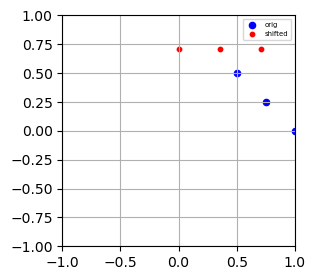

In [8]:
# testing the cart2pol functions!
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

def pol2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

testx, testy = np.array([1, .5, .75]), np.array([0, .5, .25])
testdir = 45

r, theta = cart2pol( testx, testy)
theta2 = theta + np.radians(testdir)
xtemp, ytemp = pol2cart(r, theta2)

s = 20
plt.figure(figsize=(3,3))
plt.scatter(testx, testy, c='b', label='orig', s=s)
plt.scatter(xtemp, ytemp, c='r', label='shifted', s=s/2)
plt.legend(fontsize=5)
plt.xlim([-1, 1])
plt.ylim([-1, 1])
plt.grid()

In [9]:
# use a helper fn to get the relevant years and files
tc='all'
yearlist, crlfilelist = helper_fns_winter2023.get_crl_datasets( tc=tc)
metadata = eyewall_metadata.all_metadata()


In [10]:
# goal: convert existing x and y dists into shear corrected dists

# helper fns (x and y are arrays)
def cart2pol(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(r, theta)

def pol2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return(x, y)

sheardirlist = []

# pulling shear for each case- make sure not to get shear from 08/30 and 08/31 which have no data!
# keep track of which tc we're on with this counter
flightcounter = 0
# do this for all the datasets! years and filenames
for yeari, yearval in enumerate( yearlist):
    for filei, crlname in enumerate( crlfilelist[ yeari]):        
        # print( "\n" + str(crlname))
        # print(alldates[flightcounter])
        
        # get eye time limits for each date
        date = crlname[7:11]
        # check if this date exists... if not, give it some empty eyewall limits!
        # also account for fred am and pm cases!!
        if date == '0812':
            if crlname[11:13] == "H1":
                sheardir = metadata[ yearval]['shear_dir'][ '0812am']
            elif crlname[11:13] == "H2":
                sheardir = metadata[ yearval]['shear_dir'][ '0812pm']
        elif date in metadata[ yearval]['shear_dir'].keys():
            sheardir = metadata[ yearval]['shear_dir'][ date]
        else:
            sheardir = [ ()]
        # print(sheardir)
        # print(len(alltimes[flightcounter]))
        # print(flightcounter)
        

        if crlname == 'P3_20220831H1_processed.nc' or crlname == 'P3_20220830H1_processed.nc':
            pass # print('ERROR CASE!!')
        else:
            sheardirlist.append( sheardir)
            flightcounter += 1

# print(len(sheardirlist))
# print(sheardirlist)

# save new x and y dists below
shearxdists, shearydists = [], []
# do this for every set of x and y value
for i in range(len(sheardirlist)):
    # print("\ncase " + str(i))
    # python steps
    r, theta = cart2pol( np.array(allxdists[i]), np.array(allydists[i]))
    # print(np.nanmax(theta))
    # print(np.nanmin(theta))
    
    theta2 = theta + np.radians( sheardirlist[i])
    # print(theta[0:10])
    # print(sheardirlist[i])
    # print(np.radians( sheardirlist[i]))
    # print(theta2[0:10])
    # print('\n')
    
    xtemp, ytemp = pol2cart(r, theta2)
    shearxdists.append(xtemp)
    shearydists.append(ytemp)
    
    # matlab steps
    '''
    [TH, R]=cart2pol(xr,yr);  % get earth relative theta and radius coords from xy values
    th2=TH+shd;   % find the shear relative angle of data
    [x2, y2]=pol2cart(th2, R); % go back to xy coords!
    '''

In [11]:
print(len(shearxdists))
print(shearxdists[4])

33
[449.13966601 449.06103045 448.98805544 ... 129.5937907  129.82166791
 130.08738984]


In [12]:
print(len(alldates))
print(len(alltimes))
print(len(allxdists))
print(len(allydists))

# for i in range(len(alltimes)):
#     print(len(alltimes[i]))
#     print(len(allxdists[i]))

33
33
33
33


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


non shear corrected
20220920H1
1605
1605
1605
shear corrected
20220920H1
1605
1605
1605
shear dir: 97


Text(0.5, 0, 'X Distances (km)')

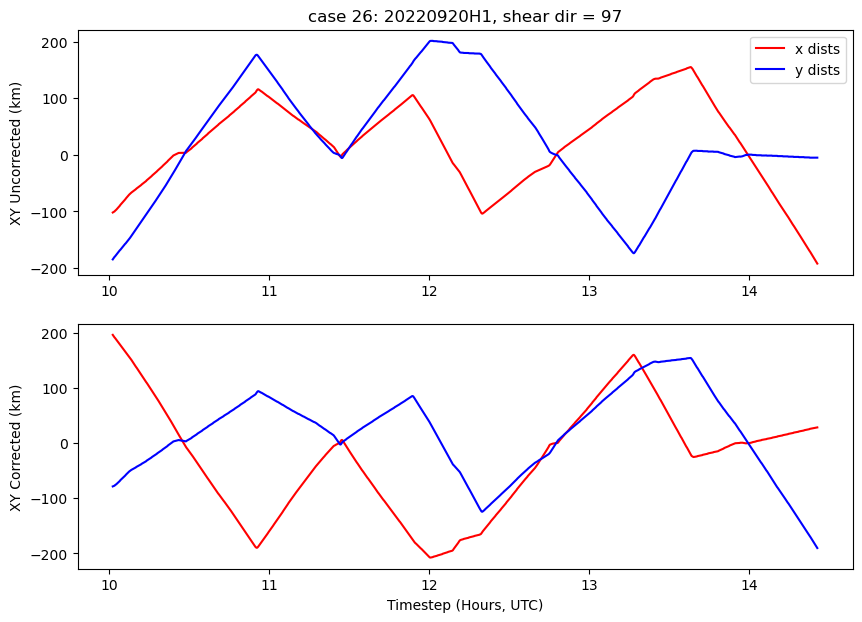

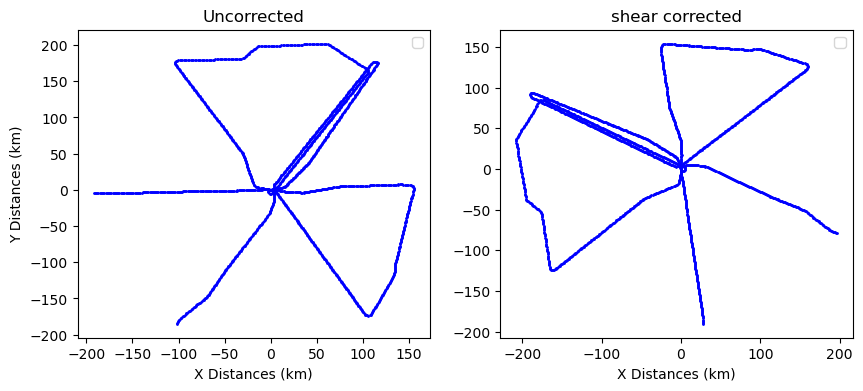

In [13]:
index = 26
print("non shear corrected")
print( alldates[index])
print( len(allxdists[index]))
print( len(allydists[index]))
print(len(alltimes[index]))

print("shear corrected")
print( alldates[index])
print( len(shearxdists[index]))
print( len(shearydists[index]))
print(len(alltimes[index]))
print("shear dir: " + str(sheardirlist[index]))

# simple test plot
plt.figure(figsize = (10, 7))
plt.subplot(211)
plt.plot(alltimes[index], allxdists[index], c='r', label='x dists')
plt.plot(alltimes[index], allydists[index], c='b', label='y dists')
plt.legend()
plt.title("case " + str(index) + ": " + alldates[index] + ", shear dir = " + str(sheardirlist[index]))
plt.ylabel("XY Uncorrected (km)")
plt.subplot(212)
plt.plot(alltimes[index], shearxdists[index], c='r', label='x dists')
plt.plot(alltimes[index], shearydists[index], c='b', label='y dists')
plt.ylabel("XY Corrected (km)")
plt.xlabel("Timestep (Hours, UTC)")


plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.scatter(allxdists[index], allydists[index], c='b', s=1)
plt.legend()
plt.ylabel("Y Distances (km)")
plt.xlabel("X Distances (km)")
plt.title("Uncorrected")
plt.subplot(122)
plt.scatter(shearxdists[index], shearydists[index], c='b', s=1)
plt.legend()
plt.title("shear corrected")
plt.xlabel("X Distances (km)")

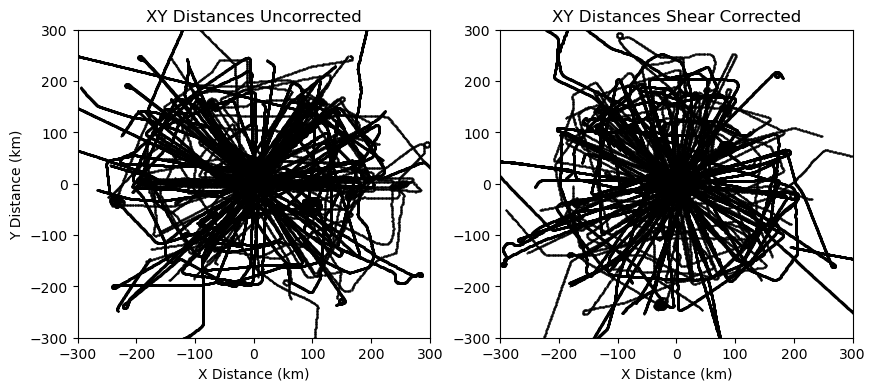

In [14]:
# 2d distance plots!

plt.figure(figsize = (10, 4))
plt.subplot(121)
plt.title("XY Distances Uncorrected")
plt.ylabel("Y Distance (km)")
plt.xlabel("X Distance (km)")
plt.xlim([-300, 300])
plt.ylim([-300, 300])
for index in range(len(allxdists)):
    plt.scatter(allxdists[index], allydists[index], c='k', s=.25)

plt.subplot(122)
plt.title("XY Distances Shear Corrected")
plt.xlabel("X Distance (km)")
plt.xlim([-300, 300])
plt.ylim([-300, 300])
for index in range(len(shearxdists)):
    plt.scatter(shearxdists[index], shearydists[index], c='k', s=.25)


86
86
86


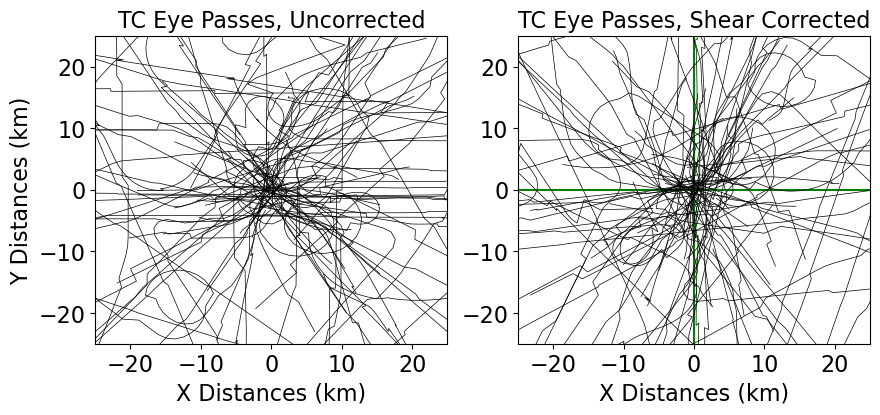

In [16]:
# the same code as above, but only do this for TC eye passes!
tc = 'all'

# add trimmed time and distance values here
datetrim, passtrim, timetrim, xtrim, ytrim, xsheartrim, ysheartrim = [], [], [], [], [], [], []

# keep track of which tc we're on with this counter
flightcounter = 0
# do this for all the datasets! years and filenames
for yeari, yearval in enumerate( yearlist):
    for filei, crlname in enumerate( crlfilelist[ yeari]):        
        # print( "\n" + str(crlname))
        # print(alldates[flightcounter])
        
        # get eye time limits for each date
        date = crlname[7:11]
        # check if this date exists... if not, give it some empty eyewall limits!
        # also account for fred am and pm cases!!
        if date == '0812':
            if crlname[11:13] == "H1":
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812am']
            elif crlname[11:13] == "H2":
                eyewall_limits = metadata[ yearval]['eyewall_limits'][ '0812pm']
        elif date in metadata[ yearval]['eyewall_limits'].keys():
            eyewall_limits = metadata[ yearval]['eyewall_limits'][ date]
        else:
            eyewall_limits = [ ()]
        # print(eyewall_limits)
        # print(len(alltimes[flightcounter]))
        # print(flightcounter)
        
        # do this for each of the eyewall limit pairs! Can have multiple eyes per crl dataset
        for eyei, eyeval in enumerate( eyewall_limits):
            if len( eyeval) > 0:
                # find the corresponding indices to the time limits
                ind0 = np.argmin( np.abs( alltimes[flightcounter] - eyeval[0] ))
                ind1 = np.argmin( np.abs( alltimes[flightcounter] - eyeval[1] ))

                # print( (ind0, ind1))
                
                if ind0 != ind1:
                    datetrim.append( crlname[3:13])
                    passtrim.append( eyei)
                    xtrim.append( allxdists[flightcounter][ind0:ind1])
                    ytrim.append( allydists[flightcounter][ind0:ind1])
                    xsheartrim.append( shearxdists[flightcounter][ind0:ind1])
                    ysheartrim.append( shearydists[flightcounter][ind0:ind1])

                    timetrim.append( alltimes[flightcounter][ind0:ind1])
                    # if shear:
                        
                else:
                    print("Error: matching indices :(")

        if crlname == 'P3_20220831H1_processed.nc' or crlname == 'P3_20220830H1_processed.nc':
            pass # print('ERROR CASE!!')
        else:
            flightcounter += 1

# convert lists to a nice dataframe!
df_dists_trim = pd.DataFrame()
df_dists_trim['flight'] = datetrim
df_dists_trim['passes'] = passtrim
df_dists_trim['times'] = timetrim
df_dists_trim['xdists'] = xtrim
df_dists_trim['ydists'] = ytrim
df_dists_trim['xdistsshear'] = xsheartrim
df_dists_trim['ydistsshear'] = ysheartrim
    
print(len(xtrim))
print(len(ytrim))
print(len(timetrim))
            

plt.figure(figsize = (10, 4))
helper_fns_winter2023.change_font_sizes(16, 16)
limx, limy = 25, 25

plt.subplot(121)
plt.title("TC Eye Passes, Uncorrected")
plt.ylabel("Y Distances (km)")
plt.xlabel("X Distances (km)")
plt.xlim([ -limx, limx])
plt.ylim([ -limy, limy])
for index in range(len(xtrim)):
    plt.plot(xtrim[index], ytrim[index], c='k', linewidth=.5)

plt.subplot(122)
plt.title("TC Eye Passes, Shear Corrected")
plt.xlabel("X Distances (km)")
plt.xlim([ -limx, limx])
plt.ylim([ -limy, limy])
plt.axvline(x=0.0, c='g')
plt.axhline(y=0.0, c='g')

for index in range(len(xtrim)):
    plt.plot(xsheartrim[index], ysheartrim[index], c='k', linewidth=.5) # s=.25)



In [27]:
df_dists_trim

,flight,passes,times,xdists,ydists,xdistsshear,ydistsshear
0,20210812H1,0,"[10.3293, 10.3298, 10.3304, 10.331, 10.3315, 1...","[-48.52001792297955, -48.343998792900976, -48....","[14.602650192169198, 14.463665004638681, 14.29...","[1.989495679737724, 2.063602532952105, 2.15197...","[-50.63073610783692, -50.4190575996856, -50.16..."
1,20210812H1,1,"[11.0487, 11.0493, 11.0499, 11.0504, 11.051, 1...","[47.071590190333865, 46.81174380439297, 46.548...","[-18.236147331390367, -18.387153999481185, -18...","[1.9176053035649068, 2.1449826215972805, 2.376...","[50.44417173904882, 50.2476451165804, 50.04914..."
2,20210812H1,2,"[12.5499, 12.5504, 12.551, 12.5515, 12.5521, 1...","[6.428544082728701, 6.432439745893894, 6.43233...","[-49.42622368267819, -49.1914884570007, -48.91...","[44.640483380838646, 44.417268560746, 44.15268...","[22.169912270435205, 22.097173378112263, 22.00..."
3,20210812H2,0,"[22.0919, 22.0925, 22.093, 22.0936, 22.0941, 2...","[-49.793750644564724, -49.53516121264132, -49....","[9.80419819235232, 9.697270286315943, 9.617759...","[-8.933684191194248, -8.831285578662193, -8.75...","[-49.95727366680472, -49.69685747002866, -49.4..."
4,20210812H2,1,"[23.348, 23.3486, 23.3491, 23.3497, 23.3503, 2...","[13.372520218391681, 13.203701940561656, 13.07...","[48.50058992623916, 48.23738277291885, 48.0184...","[-48.72658570941767, -48.46047235862295, -48.2...","[12.524031510950437, 12.359832543178756, 12.23..."
...,...,...,...,...,...,...,...
81,20221007H1,1,"[23.4492, 23.452, 23.4547, 23.4575, 23.4603, 2...","[50.51216121701602, 49.06980252538929, 47.6871...","[5.7305107103576045, 5.99751412069696, 6.24564...","[-31.627116004872924, -31.08921408205128, -30....","[39.8000341335237, 38.4353543403602, 37.131296..."
82,20221007H1,2,"[24.650082, 24.652859, 24.655636, 24.658415, 2...","[0.49680698509282023, 1.1368934299789264, 1.78...","[6.58958595790106, 7.6506397947235705, 8.71190...","[-5.851553418063418, -7.090572242219912, -8.33...","[-3.070632324547209, -3.090081102106814, -3.10..."
83,20221008H1,0,"[22.1004, 22.1032, 22.106, 22.1088, 22.1115, 2...","[44.558691357338766, 43.16925844265163, 41.784...","[22.516489547698978, 22.8560436477356, 23.1852...","[-37.78787595884755, -36.357569568239924, -34....","[-32.627376657478386, -32.62071030505373, -32...."
84,20221008H1,1,"[23.1588, 23.1616, 23.1643, 23.1671, 23.1699, ...","[-39.02339782089225, -38.307090531067495, -37....","[-0.4406188980102932, 0.5179359992980564, 1.44...","[37.7576407713361, 37.29450628711198, 36.84313...","[9.868145007226019, 8.764772869580538, 7.70030..."


In [32]:
index2 = 84
# print(len(df_dists_trim['xdists'][index2]))
# print(len(df_dists_trim['ydists'][index2]))
# print(len(df_dists_trim['xdistsshear'][index2]))
# print(df_dists_trim['xdists'][index2])

# find how many eye pass data points there are!
total_points = 0

for casei in range(len(df_dists_trim['flight'])):
    lengthi = len(df_dists_trim['xdists'][casei])
    total_points += lengthi
    print("Case " + str(casei) + ": " + str(lengthi))
print("Total: " + str(total_points))

Case 0: 343
Case 1: 218
Case 2: 378
Case 3: 374
Case 4: 368
Case 5: 125
Case 6: 371
Case 7: 385
Case 8: 323
Case 9: 510
Case 10: 350
Case 11: 377
Case 12: 99
Case 13: 160
Case 14: 130
Case 15: 162
Case 16: 225
Case 17: 305
Case 18: 404
Case 19: 404
Case 20: 145
Case 21: 129
Case 22: 179
Case 23: 269
Case 24: 196
Case 25: 99
Case 26: 207
Case 27: 180
Case 28: 68
Case 29: 184
Case 30: 88
Case 31: 129
Case 32: 118
Case 33: 77
Case 34: 181
Case 35: 160
Case 36: 75
Case 37: 72
Case 38: 83
Case 39: 91
Case 40: 76
Case 41: 81
Case 42: 77
Case 43: 84
Case 44: 96
Case 45: 76
Case 46: 54
Case 47: 79
Case 48: 73
Case 49: 91
Case 50: 78
Case 51: 252
Case 52: 288
Case 53: 162
Case 54: 81
Case 55: 77
Case 56: 86
Case 57: 73
Case 58: 86
Case 59: 22
Case 60: 26
Case 61: 55
Case 62: 102
Case 63: 58
Case 64: 36
Case 65: 14
Case 66: 15
Case 67: 30
Case 68: 115
Case 69: 72
Case 70: 72
Case 71: 89
Case 72: 76
Case 73: 33
Case 74: 33
Case 75: 25
Case 76: 49
Case 77: 14
Case 78: 18
Case 79: 11
Case 80: 65
Ca

In [51]:
# concatenate all the x and y shear distances together... then, sort for quadrants!

allxshear, allyshear = [], []
for casei in range(len(df_dists_trim['flight'])):
    allxshear += df_dists_trim['xdistsshear'][casei].tolist()
    allyshear += df_dists_trim['ydistsshear'][casei].tolist()

print("Total cases: " + str(len(allxshear)))

# now, search by quadrant!
nancount = 0
xquads = [ [], [], [], []] # DL, DR, UR, UL
yquads = [ [], [], [], []]
for cloudi in range(len(allxshear)):
    xi, yi = allxshear[cloudi], allyshear[cloudi]

    if np.isnan(xi):
        nancount += 1

    # DL case
    if xi < 0.0 and yi > 0.0:
        xquads[0].append(xi)
        yquads[0].append(yi)
    # DR case
    elif xi > 0.0 and yi > 0.0:
        xquads[1].append(xi)
        yquads[1].append(yi)
    # UR case
    elif xi > 0.0 and yi < 0.0:
        xquads[2].append(xi)
        yquads[2].append(yi)
    # UL case
    elif xi < 0.0 and yi < 0.0:
        xquads[3].append(xi)
        yquads[3].append(yi)    

print("nan cases: " + str(nancount))

quads = ['DL', 'DR', 'UR', 'UL']
for i in range(4):
    print("# " + quads[i] + "cases: " + str( len(xquads[i])))
    
    print(quads[i] + " data % = " + str( np.round( (len(xquads[i]) / len(allxshear) ) * 100, 3)))

Total cases: 11997
nan cases: 230
# DLcases: 2315
DL data % = 19.296
# DRcases: 4026
DR data % = 33.558
# URcases: 2634
UR data % = 21.955
# ULcases: 2792
UL data % = 23.272
